In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

# 数据获取

In [2]:
df_wine = pd.read_csv('wine.data',header=None)

该数据集是UCI的公开数据集，是对意大利同一地区种植的葡萄酒进行分析的结果，数据集共14列数据，第一个属性是类标识符，分别是1/2/3来表示，代表葡萄酒的三个分类。剩余的13个属性是，酒精、苹果酸、灰、灰分的碱度、镁、总酚、黄酮类化合物、非黄烷类酚类、原花色素、颜色强度、色调等。

In [3]:
# 设置列索引
df_wine.columns =  ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

In [4]:
# 数据维度
df_wine.shape

(178, 14)

In [5]:
# 每一类数据包含的样本个数
df_wine['Class label'].value_counts()

2    71
1    59
3    48
Name: Class label, dtype: int64

In [6]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# 数据集划分

In [7]:
# 
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

In [8]:
# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y,
                                                    random_state=0)

# 数据标准化

In [9]:
# 实例化
sc = StandardScaler()

In [10]:
# 对数据集进行标准化
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# PCA(Pricipal component analysis)

## PCA实现

### 特征值计算

In [11]:
N = X_train_std.shape[0]
H = np.identity(N) - np.outer(np.ones(N), np.ones(N)) / N

In [12]:
# 计算协方差矩阵
cov_mat = np.dot(np.transpose(X_train_std), np.dot(H, X_train_std)) / N

In [13]:
# 对协方差矩阵进行特征值分解
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

### 特征值分布

In [14]:
# 特征值之和
tot = sum(eigen_vals)

In [15]:
# 对特征(eigen_vals)进行排序
var_exp = sorted(eigen_vals, reverse=True)

In [16]:
# 累计求和
cum_var_exp = np.cumsum(var_exp)

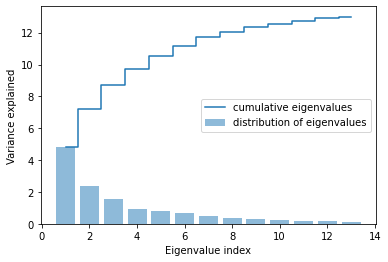

In [17]:
# 绘制图像
plt.figure()
#
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='distribution of eigenvalues')
#
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative eigenvalues')
plt.ylabel('Variance explained')
plt.xlabel('Eigenvalue index')
plt.legend(loc='best')

### 特征降维

In [18]:
# 创建列表，由(eigenvalue, eigenvector)元组构成
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

In [19]:
# 
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [20]:
# 取前两个特征值对应的特征向量作为主要成分
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

In [21]:
# 原始特征（以第一个样本为例）
X_train_std[0]

array([ 0.71225893,  2.22048673, -0.13025864,  0.05962872, -0.50432733,
       -0.52831584, -1.24000033,  0.84118003, -1.05215112, -0.29218864,
       -0.20017028, -0.82164144, -0.62946362])

In [22]:
# 特征压缩后结果
np.dot(np.transpose(w),X_train_std[0])

array([2.38299011, 0.45458499])

In [23]:
# 全部特征压缩
X_train_pca = np.dot(X_train_std, w)

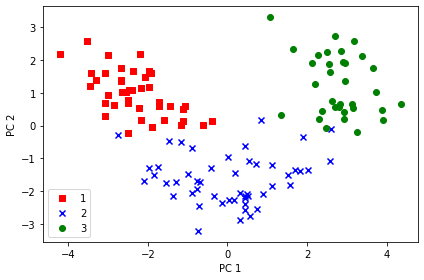

In [24]:
# 特征压缩后结果展示
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    # 按照样本的真实值进行展示
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 使用sklearn实现PCA

sklearn中提供了进行PCA的API

### 特征值计算

In [25]:
# 实例化pca，保留所有特征
pca = PCA()

In [26]:
# 特征提取
X_train_pca = pca.fit_transform(X_train_std)

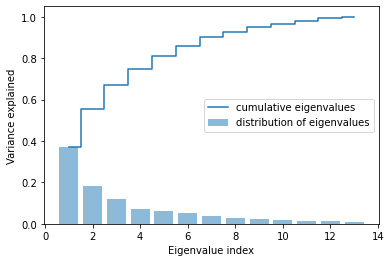

In [27]:
# 绘制图像
plt.figure()
#
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center',
        label='distribution of eigenvalues')
#
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='cumulative eigenvalues')
plt.ylabel('Variance explained')
plt.xlabel('Eigenvalue index')
plt.legend(loc='best')

### 特征降维

In [28]:
# 压缩到二维特征
pca = PCA(n_components=2)

In [29]:
# 对训练数据进行降维
X_train_pca = pca.fit_transform(X_train_std)

In [30]:
# 特征值结果(只保留两个特征)
print(pca.explained_variance_ratio_)

[0.36951469 0.18434927]


In [31]:
# 对测试集数据进行降维
X_test_pca = pca.fit_transform(X_test_std)

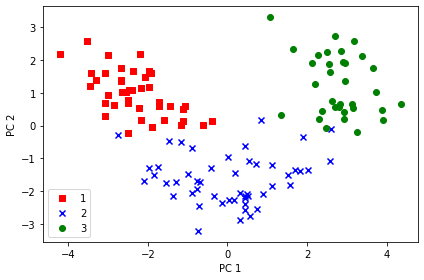

In [32]:
# 特征降维后结果展示
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    # 按照样本的真实值进行展示
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 利用逻辑回归进行分类

### 绘制函数

In [33]:
# 绘制样本及其目标值
def plot_decision_regions(X, y, classifier, resolution=0.02):
    """
    X:样本特征值
    y:目标值
    classifier: 分类器
    """
    # 设置图像的标记及颜色
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 利用样本点创建meshgrid
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # 预测结果
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    # 绘制预测结果的等高线
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 绘制样本点,并根据真实值进行着色
    for idx, cl in enumerate(np.unique(y)):
        # 绘制散点图
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

### PCA特征降维

In [34]:
# 利用PCA进行特征降维
# 保留两维特征
pca = PCA(n_components=2)
# 训练集数据处理
X_train_pca = pca.fit_transform(X_train_std)
# 测试集数据处理
X_test_pca = pca.transform(X_test_std)

### LR分类器

In [35]:
# 实例化
lr = LogisticRegression()
# 模型训练
lr = lr.fit(X_train_pca, y_train)

### 训练数据结果

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/nl/5xqj0k597kv06_pyjvngz2p40000gp/T/ipykernel_63356/2995315095.py:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
*c* argument looks like a single numeric RGB or RGBA sequen

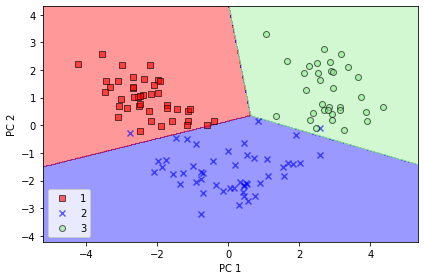

In [36]:
#
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### 测试数据结果

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/nl/5xqj0k597kv06_pyjvngz2p40000gp/T/ipykernel_63356/2995315095.py:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
*c* argument looks like a single numeric RGB or RGBA sequen

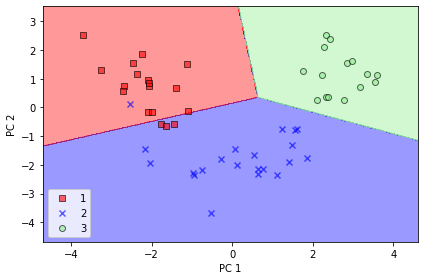

In [37]:
#
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# LDA(Linear discriminant analysis)

## LDA实现

In [38]:
# 精度设置,浮点数
np.set_printoptions(precision=4)

### 平均向量

In [39]:
# 计算每一类数据的平均向量
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))

### 类内散度矩阵Sw

In [40]:
# 特征维度
d = 13 
S_W = np.zeros((d, d))
# 获取每个类别的平均值向量
for label, mv in zip(range(1, 4), mean_vecs):
    # 每一类别的散度矩阵
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        # 列向量
        row, mv = row.reshape(d, 1), mv.reshape(d, 1) 
        class_scatter += np.dot(row - mv, (row - mv).T)
    # 每个类别散度矩阵之和
    S_W += class_scatter                         

### 类间散度矩阵SB

In [41]:
# 全局平均值
mean_overall = np.mean(X_train_std, axis=0)
# 特征维度
d = 13  
S_B = np.zeros((d, d))
# 获取每个类别的平均值
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    # 列向量
    mean_vec = mean_vec.reshape(d, 1)  
    mean_overall = mean_overall.reshape(d, 1)  
    # 类间散度矩阵
    S_B += n*np.dot(mean_vec-mean_overall, (mean_vec-mean_overall).T)

### 特征值计算

求解矩阵 $S_W^{-1}S_B$的特征值和特征向量

In [42]:
# 计算LDA的特征值
eigen_vals, eigen_vecs = np.linalg.eig(np.dot(np.linalg.inv(S_W), S_B))

In [43]:
eigen_vals

array([-8.8818e-16+0.0000e+00j,  4.2257e+00+0.0000e+00j,
        8.2625e+00+0.0000e+00j, -4.9896e-17+6.1916e-16j,
       -4.9896e-17-6.1916e-16j, -4.6033e-16+0.0000e+00j,
        4.2709e-16+0.0000e+00j,  3.2987e-16+0.0000e+00j,
        1.2007e-16+1.8323e-16j,  1.2007e-16-1.8323e-16j,
       -2.0953e-16+1.0282e-17j, -2.0953e-16-1.0282e-17j,
        6.1027e-18+0.0000e+00j])

In [44]:
# 创建由特征值和特征向量组成的list
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# 根据特征值从大到小排序(eigenvalue, eigenvector)
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

### 特征降维

In [45]:
# 保留两维特征
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))

In [46]:
# 特征降维
X_train_lda = np.dot(X_train_std,w)

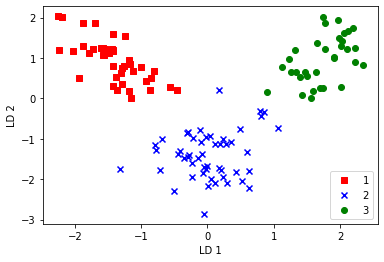

In [47]:
# 结果绘制
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

## 使用sklearn实现LDA并进行LR分类

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# 实例化 (保留二维)
lda = LDA(n_components=2)

In [49]:
# 对训练数据进行LDA处理
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [50]:
# 实例化逻辑回归
lr = LogisticRegression()
# 训练
lr = lr.fit(X_train_lda, y_train)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/nl/5xqj0k597kv06_pyjvngz2p40000gp/T/ipykernel_63356/2995315095.py:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
*c* argument looks like a single numeric RGB or RGBA sequen

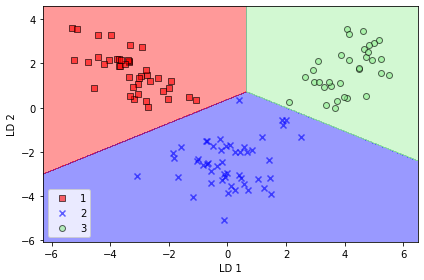

In [51]:
# 训练数据结果
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/nl/5xqj0k597kv06_pyjvngz2p40000gp/T/ipykernel_63356/2995315095.py:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
*c* argument looks like a single numeric RGB or RGBA sequen

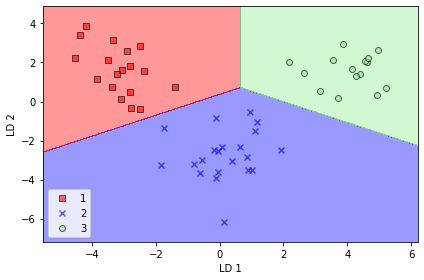

In [52]:
# 测试数据结果
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test,classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()